# Insurance Document Parser - Testing Notebook

This notebook tests the insurance document parser on sample PDF files.

## Objectives
1. Load and test the parser on sample documents
2. Examine extracted fields and confidence scores
3. Identify patterns that work well and areas for improvement
4. Document edge cases and errors

## 1. Setup and Imports

In [1]:
import sys
import os
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Add parent directory to path to import parser
sys.path.append('..')

from insurance_parser import InsuranceDocumentParser, ExtractionResult

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Imports successful")

✓ Imports successful


## 2. Initialize Parser

In [2]:
# Initialize the parser
parser = InsuranceDocumentParser()
print("✓ Parser initialized")

# Define paths
SAMPLE_DOCS_DIR = Path('../sample_documents')
RESULTS_DIR = Path('../test_results')
RESULTS_DIR.mkdir(exist_ok=True)

print(f"Sample documents directory: {SAMPLE_DOCS_DIR}")
print(f"Results directory: {RESULTS_DIR}")

✓ Parser initialized
Sample documents directory: ..\sample_documents
Results directory: ..\test_results


## 3. List Available Sample Documents

In [8]:
# Find all PDF files in sample_documents directory
pdf_files = list(SAMPLE_DOCS_DIR.rglob('*.pdf'))

print(f"Found {len(pdf_files)} PDF files:\n")
for i, pdf_file in enumerate(pdf_files, 1):
    print(f"{i}. {pdf_file.name} ({pdf_file.stat().st_size / 1024:.1f} KB)")

if len(pdf_files) == 0:
    print("\n⚠️ No PDF files found. Please add sample insurance documents to the 'sample_documents' folder.")

Found 2 PDF files:

1. car policy.pdf (777.3 KB)
2. Policy1_5645166.pdf (116.6 KB)


## 4. Test Single Document Extraction

In [9]:
# Select a document to test (change index as needed)
if len(pdf_files) > 0:
    test_doc = pdf_files[1]  # Change index to test different documents
    print(f"Testing document: {test_doc.name}\n")
    print("=" * 70)
    
    # Parse the document
    result = parser.parse_pdf(str(test_doc))
    
    # Display metadata
    print("\nDOCUMENT METADATA")
    print("=" * 70)
    for key, value in result.document_metadata.items():
        print(f"{key:20s}: {value}")
    
    # Display extracted fields
    print("\n\nEXTRACTED FIELDS")
    print("=" * 70)
    print(f"Total fields extracted: {len(result.fields)}\n")
    
    for field_name, field_data in sorted(result.fields.items()):
        print(f"\n{field_name.upper().replace('_', ' ')}:")
        print(f"  Value:      {field_data.value}")
        print(f"  Confidence: {field_data.confidence:.2%}")
        print(f"  Page:       {field_data.page}")
        print(f"  Context:    {field_data.context[:80]}...")
    
    # Display tables
    if result.tables_extracted:
        print("\n\nEXTRACTED TABLES")
        print("=" * 70)
        print(f"Total tables: {len(result.tables_extracted)}\n")
        for i, table in enumerate(result.tables_extracted, 1):
            print(f"Table {i}:")
            print(f"  Type: {table['table_type']}")
            print(f"  Page: {table['page']}")
            print(f"  Rows: {len(table['rows'])}")
    
    # Display warnings
    if result.warnings:
        print("\n\nWARNINGS")
        print("=" * 70)
        for warning in result.warnings:
            print(f"⚠️  {warning}")
    
    # Save results
    output_file = RESULTS_DIR / f"{test_doc.stem}_results.json"
    with open(output_file, 'w') as f:
        f.write(result.to_json())
    print(f"\n\n✓ Results saved to: {output_file}")
    
else:
    print("No documents available to test")

Testing document: Policy1_5645166.pdf


DOCUMENT METADATA
filename            : Policy1_5645166.pdf
extraction_timestamp: 2026-02-07T03:21:00.418611
pages               : 2
document_type       : auto_insurance


EXTRACTED FIELDS
Total fields extracted: 10


DEDUCTIBLE:
  Value:      1000.0
  Confidence: 91.75%
  Page:       1
  Context:    cheque 5.The policy is subject to compulsory deductible of INR 1,000 (IMT-
22) &...

DISCOUNT:
  Value:      2.0
  Confidence: 81.77%
  Page:       1
  Context:    Sub Total (Basic Premium) 6,226 PA cover for Paid Driver of Rs 2 Lac (IMT-17) 0
...

EXPIRY DATE:
  Value:      30/05/2028
  Confidence: 62.59%
  Page:       2
  Context:    to
Expiry)
Broker Code: 822 (Valid UPTO:30/05/2028) MISP NAME-ASHVAR AUTOMOBILES...

GST AMOUNT:
  Value:      658.0
  Confidence: 90.00%
  Page:       1
  Context:    From table: Add On Coverages ( ZD ) 6587 CGST(9%)  1492...

ISSUE DATE:
  Value:      29-NOV-2025
  Confidence: 70.86%
  Page:       1
  Context:    000

## 5. Batch Process All Documents

In [10]:
# Process all documents and collect results
all_results = []

for pdf_file in pdf_files:
    print(f"Processing: {pdf_file.name}...")
    try:
        result = parser.parse_pdf(str(pdf_file))
        all_results.append({
            'filename': pdf_file.name,
            'result': result,
            'fields_count': len(result.fields),
            'document_type': result.document_metadata['document_type'],
            'pages': result.document_metadata['pages']
        })
        print(f"  ✓ Extracted {len(result.fields)} fields")
    except Exception as e:
        print(f"  ✗ Error: {e}")
        all_results.append({
            'filename': pdf_file.name,
            'result': None,
            'error': str(e)
        })

print(f"\n✓ Processed {len(all_results)} documents")

Processing: car policy.pdf...
  ✓ Extracted 9 fields
Processing: Policy1_5645166.pdf...
  ✓ Extracted 10 fields

✓ Processed 2 documents


## 6. Summary Statistics

In [11]:
# Create summary DataFrame
summary_data = []
for res in all_results:
    if res.get('result'):
        summary_data.append({
            'Document': res['filename'],
            'Type': res['document_type'],
            'Pages': res['pages'],
            'Fields Extracted': res['fields_count'],
            'Avg Confidence': sum(f.confidence for f in res['result'].fields.values()) / len(res['result'].fields) if res['result'].fields else 0
        })

if summary_data:
    summary_df = pd.DataFrame(summary_data)
    print("\nSUMMARY STATISTICS")
    print("=" * 70)
    print(summary_df.to_string(index=False))
    print("\n")
    print(summary_df.describe())
else:
    print("No successful extractions to summarize")


SUMMARY STATISTICS
           Document           Type  Pages  Fields Extracted  Avg Confidence
     car policy.pdf auto_insurance      6                 9        0.838811
Policy1_5645166.pdf auto_insurance      2                10        0.849906


          Pages  Fields Extracted  Avg Confidence
count  2.000000          2.000000        2.000000
mean   4.000000          9.500000        0.844358
std    2.828427          0.707107        0.007846
min    2.000000          9.000000        0.838811
25%    3.000000          9.250000        0.841585
50%    4.000000          9.500000        0.844358
75%    5.000000          9.750000        0.847132
max    6.000000         10.000000        0.849906


## 7. Visualize Confidence Scores

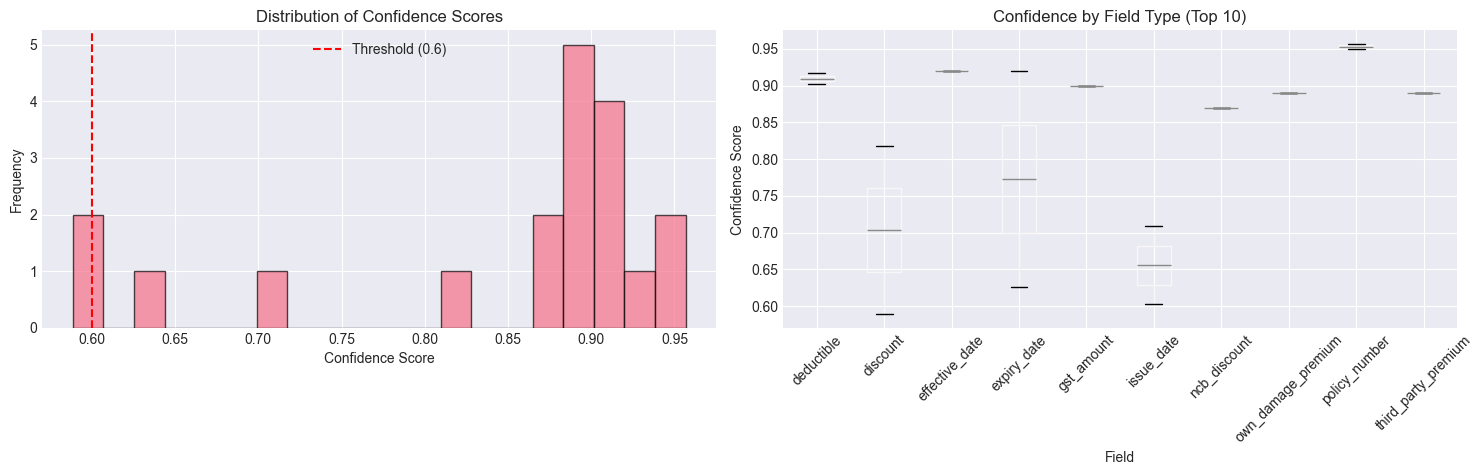


✓ Visualization saved to ..\test_results\confidence_analysis.png


In [12]:
# Collect all confidence scores
confidence_data = []
for res in all_results:
    if res.get('result'):
        for field_name, field_data in res['result'].fields.items():
            confidence_data.append({
                'Field': field_name,
                'Confidence': field_data.confidence,
                'Document': res['filename']
            })

if confidence_data:
    conf_df = pd.DataFrame(confidence_data)
    
    # Plot confidence distribution
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram
    axes[0].hist(conf_df['Confidence'], bins=20, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Confidence Score')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Confidence Scores')
    axes[0].axvline(0.6, color='red', linestyle='--', label='Threshold (0.6)')
    axes[0].legend()
    
    # Box plot by field type
    field_counts = conf_df['Field'].value_counts()
    top_fields = field_counts.head(10).index
    conf_df_top = conf_df[conf_df['Field'].isin(top_fields)]
    
    conf_df_top.boxplot(column='Confidence', by='Field', ax=axes[1], rot=45)
    axes[1].set_title('Confidence by Field Type (Top 10)')
    axes[1].set_xlabel('Field')
    axes[1].set_ylabel('Confidence Score')
    plt.suptitle('')  # Remove default title
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'confidence_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Visualization saved to {RESULTS_DIR / 'confidence_analysis.png'}")
else:
    print("No confidence data to visualize")

## 8. Field Extraction Success Rate

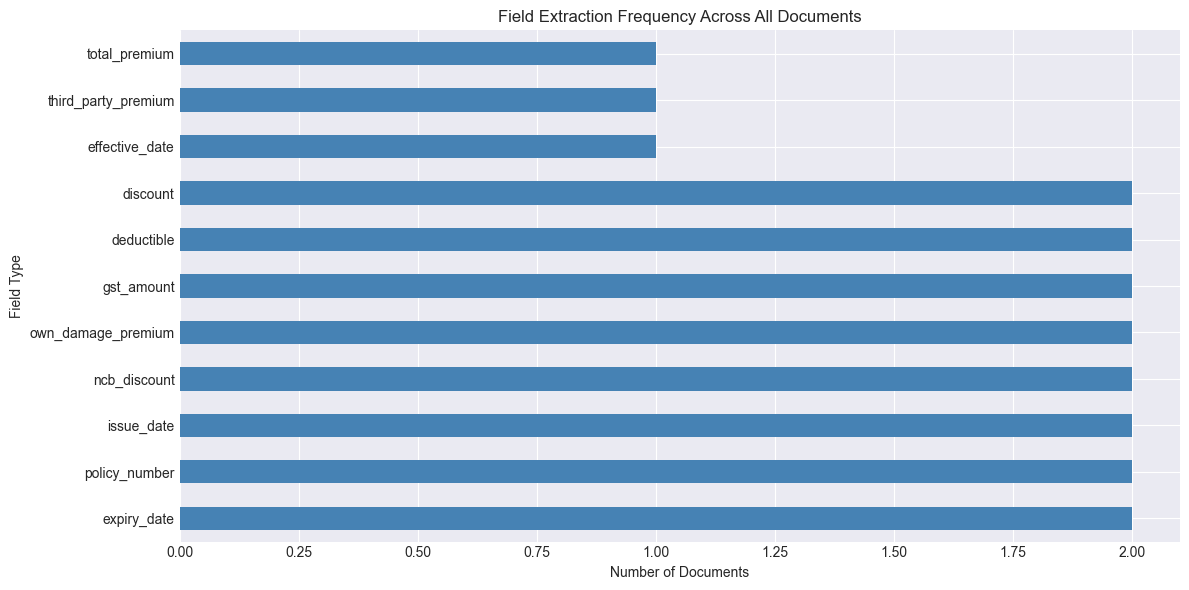


FIELD EXTRACTION FREQUENCY
Field
expiry_date            2
policy_number          2
issue_date             2
ncb_discount           2
own_damage_premium     2
gst_amount             2
deductible             2
discount               2
effective_date         1
third_party_premium    1
total_premium          1


In [13]:
# Count how often each field type is extracted
if confidence_data:
    field_counts = conf_df['Field'].value_counts()
    
    plt.figure(figsize=(12, 6))
    field_counts.plot(kind='barh', color='steelblue')
    plt.xlabel('Number of Documents')
    plt.ylabel('Field Type')
    plt.title('Field Extraction Frequency Across All Documents')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'field_frequency.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nFIELD EXTRACTION FREQUENCY")
    print("=" * 70)
    print(field_counts.to_string())
else:
    print("No field data to analyze")

## 9. Low Confidence Fields Analysis

In [10]:
# Identify fields with low confidence scores
if confidence_data:
    low_confidence_threshold = 0.6
    low_conf_df = conf_df[conf_df['Confidence'] < low_confidence_threshold]
    
    print(f"\nLOW CONFIDENCE FIELDS (< {low_confidence_threshold})")
    print("=" * 70)
    print(f"Total: {len(low_conf_df)} out of {len(conf_df)} ({len(low_conf_df)/len(conf_df)*100:.1f}%)\n")
    
    if len(low_conf_df) > 0:
        print(low_conf_df.sort_values('Confidence').to_string(index=False))
        
        # Recommendations
        print("\n\nRECOMMENDATIONS:")
        print("-" * 70)
        for field in low_conf_df['Field'].unique():
            print(f"• Review context keywords for '{field}'")
    else:
        print("✓ All fields have acceptable confidence scores!")
else:
    print("No confidence data to analyze")


LOW CONFIDENCE FIELDS (< 0.6)
Total: 1 out of 9 (11.1%)

   Field  Confidence       Document
discount    0.588533 car policy.pdf


RECOMMENDATIONS:
----------------------------------------------------------------------
• Review context keywords for 'discount'


## 10. Export Summary Report

In [13]:
# Create comprehensive summary report
report = {
    'test_date': datetime.now().isoformat(),
    'total_documents': len(pdf_files),
    'successful_extractions': len([r for r in all_results if r.get('result')]),
    'failed_extractions': len([r for r in all_results if not r.get('result')]),
    'total_fields_extracted': sum(r.get('fields_count', 0) for r in all_results),
    'average_confidence': conf_df['Confidence'].mean() if confidence_data else 0,
    'low_confidence_count': len(low_conf_df) if confidence_data else 0,
    'field_types_found': list(field_counts.index) if confidence_data else [],
    'document_types': [r['document_type'] for r in all_results if r.get('result')]
}

report_file = RESULTS_DIR / f"test_summary_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(report_file, 'w') as f:
    json.dump(report, f, indent=2)

print("\nTEST SUMMARY REPORT")
print("=" * 70)
print(json.dumps(report, indent=2))
print(f"\n✓ Report saved to: {report_file}")


TEST SUMMARY REPORT
{
  "test_date": "2026-02-05T22:40:55.018824",
  "total_documents": 1,
  "successful_extractions": 1,
  "failed_extractions": 0,
  "total_fields_extracted": 4,
  "average_confidence": 0.7638625222423494,
  "low_confidence_count": 1,
  "field_types_found": [
    "policy_number",
    "deductible",
    "discount",
    "gst_amount"
  ],
  "document_types": [
    "health_insurance"
  ]
}

✓ Report saved to: ..\test_results\test_summary_20260205_224055.json


## 11. Next Steps

Based on the test results:

1. **Review low confidence fields** - Check if context keywords need improvement
2. **Examine failed extractions** - Identify patterns in documents that failed
3. **Test edge cases** - Try scanned PDFs, poor quality documents, unusual formats
4. **Refine patterns** - Update regex patterns in `insurance_parser.py` if needed
5. **Add new field types** - If you find fields not currently extracted

**Proceed to:**
- `02_results_visualization.ipynb` for detailed visualizations
- `03_pattern_refinement.ipynb` for pattern optimization